Intento de crear una CGAN con los datos de minecraft

posibles mejoras
comprobar que el embeding y el ruido se normalizan (para q uno no se coma al otro en la generacion)
proyectar el embedding y sumarlo al vector latente (en vez de concatenar)
ponderar el embeding frente al ruido (para considerarlo mas)
reducir la dimension del espacio latente 

## Data

In [1]:
import pandas as pd
from PIL import Image
import io
import matplotlib.pyplot as plt
import re
from typing import List
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

df=pd.read_parquet("datos/minecraft.parquet")

## Code

informacion relevante:
las imagenes componen valores entre [-1,1] por eso se usa funcion tanh y no sigmoid

In [2]:
def mostrar_imagen(row):
    """
    Muestra una imagen y su etiqueta desde una fila del DataFrame.
    """
    # Obtener los bytes de la imagen
    image_bytes = row['image']['bytes']

    img = Image.open(io.BytesIO(image_bytes))
    
    # Mostrar imagen con su etiqueta
    plt.imshow(img)
    plt.axis("off")
    plt.title(row['label'])
    plt.show()

# Dataset único (con augment opcional)
class MinecraftDataset(Dataset):
    def __init__(self, rows: List[dict], image_size=16, augment=False, transform=None):
        self.rows = rows
        self.image_size = image_size
        self.augment = augment

        if transform is None:
            self.transform = T.Compose([
                T.Resize((image_size, image_size)),
                T.ToTensor(),
                T.Normalize([0.5]*3, [0.5]*3)
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows[idx]
        img = Image.open(io.BytesIO(r["image"]["bytes"])).convert("RGB")
        img_t = self.transform(img)
        if self.augment and torch.rand(1).item() > 0.5:
            img_t = torch.flip(img_t, dims=[2])
        label = r["label"]
        return img_t, label


# Embedding textual (por palabra)
class TextEmbedding(nn.Module):
    def __init__(self, vocab, embed_dim=100):
        super().__init__()
        self.vocab = vocab
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.embedding = nn.Embedding(len(vocab), embed_dim)

    @staticmethod
    def build_vocab(labels):
        words = set()
        for lbl in labels:
            for w in re.findall(r"\w+", lbl.lower()):
                words.add(w)
        return sorted(words)

    def forward(self, label_texts: List[str]):
        device = next(self.embedding.parameters()).device
        vectors = []
        for text in label_texts:
            tokens = [w for w in re.findall(r"\w+", text.lower()) if w in self.stoi]
            if not tokens:
                tokens = ["unknown"]
            idxs = torch.tensor([self.stoi[w] for w in tokens], device=device)
            emb = self.embedding(idxs).mean(dim=0)
            vectors.append(emb)
        return torch.stack(vectors)



#### Crear Modelo

In [3]:
# Generator (2 capas + salida → 16×16)
class Generator(nn.Module):
    def __init__(self, nz=100, embed_dim=100, ngf=32, out_channels=3):
        super().__init__()
        # proyección inicial a 4×4
        self.fc = nn.Linear(nz + embed_dim, ngf * 4 * 4 * 4)

        self.net = nn.Sequential(
            # 4×4 → 8×8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # 8×8 → 16×16 (salida)
            nn.ConvTranspose2d(ngf * 2, out_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, cond_emb):
        x = torch.cat([z, cond_emb], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), -1, 4, 4)
        return self.net(x)


# Discriminator (2 capas + salida)
class Discriminator(nn.Module):
    def __init__(self, embed_dim=100, ndf=32, in_channels=3):
        super().__init__()
        self.fc_cond = nn.Linear(embed_dim, 16 * 16)  # mapa 1 canal

        self.net = nn.Sequential(
            # 3+1 = 4 canales → 16×16 → 8×8
            nn.Conv2d(in_channels + 1, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 8×8 → 4×4
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # salida (4×4 → escalar)
            nn.Flatten(),
            nn.Linear(ndf * 4 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img, cond_emb):
        B, C, H, W = img.shape
        cond_map = self.fc_cond(cond_emb).view(B, 1, H, W)
        x = torch.cat([img, cond_map], dim=1)
        return self.net(x).view(-1, 1).squeeze(1)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
nz = 100             # tamaño del vector de ruido
embed_dim = 100      # dimensión del embedding textual
num_epochs = 2000
lr = 1e-3 
beta1 = 0.5
print(device)

cuda


In [38]:
# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))

vocab = TextEmbedding.build_vocab(all_labels)

print(f" Vocabulario generado con {len(vocab)} palabras únicas:")
# print(vocab)

# Dataset y DataLoader
dataset = MinecraftDataset(df.to_dict("records"), image_size=16, augment=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


 Vocabulario generado con 351 palabras únicas:


#### Entrenamiento

In [13]:
# MODELOS
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim).to(device)
G = Generator(nz=nz, embed_dim=embed_dim).to(device)
D = Discriminator(embed_dim=embed_dim).to(device)

# Pérdida y optimizadores
criterion = nn.BCELoss()
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))


[0/50][0/10] Loss_D: 1.4915 Loss_G: 0.7920


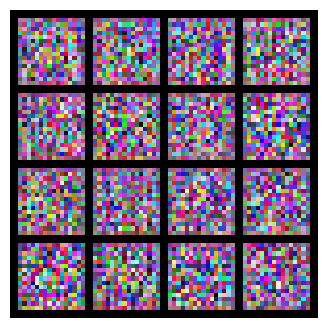

[1/50][0/10] Loss_D: 0.3485 Loss_G: 1.8448


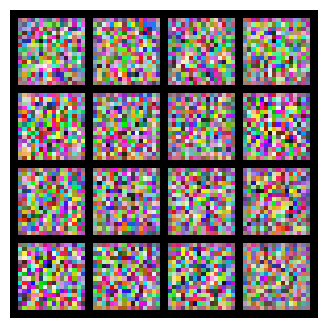

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils

# --- Hiperparámetros ---
batch_size = 64
nz = 100             # tamaño del vector latente z
embed_dim = 100      # dimensión del embedding textual
lr = 0.0002
beta1 = 0.5
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Preparar dataset ---
dataset = MinecraftDataset(df.to_dict(orient="records"), image_size=16, augment=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# --- Construir embeddings, generator y discriminator ---
vocab = TextEmbedding.build_vocab(df['label'])
text_embedding = TextEmbedding(vocab, embed_dim=embed_dim).to(device)

netG = Generator(nz=nz, embed_dim=embed_dim).to(device)
netD = Discriminator(embed_dim=embed_dim).to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# --- Etiquetas reales y falsas ---
real_label = 1.
fake_label = 0.

# --- Entrenamiento ---
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.to(device)
        labels = list(labels)
        cond_emb = text_embedding(labels)

        # --- Entrenar Discriminador ---
        netD.zero_grad()
        b_size = imgs.size(0)

        # real images
        label_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(imgs, cond_emb)
        lossD_real = criterion(output, label_real)
        lossD_real.backward(retain_graph=True)


        # fake images
        noise = torch.randn(b_size, nz, device=device)
        fake_imgs = netG(noise, cond_emb)
        label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        output = netD(fake_imgs.detach(), cond_emb)
        lossD_fake = criterion(output, label_fake)
        lossD_fake.backward(retain_graph=True)

        optimizerD.step()
        lossD = lossD_real + lossD_fake

        # --- Entrenar Generator ---
        netG.zero_grad()
        label_gen = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(fake_imgs, cond_emb)
        lossG = criterion(output, label_gen)
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f}")

    # --- Guardar imágenes de ejemplo ---
    with torch.no_grad():
        fixed_noise = torch.randn(16, nz, device=device)
        sample_labels = df['label'].iloc[:16].tolist()
        cond_emb = text_embedding(sample_labels)
        fake = netG(fixed_noise, cond_emb)
        fake = (fake + 1) / 2  # desnormalizar
        grid = vutils.make_grid(fake, nrow=4)
        plt.figure(figsize=(4,4))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.show()


In [ ]:
# GUARDAR MODELOS
torch.save(G.state_dict(), "generator_cgan16.pth")
torch.save(D.state_dict(), "discriminator_cgan16.pth")
print(" Modelos guardados.")


Época [320/2000] Loss_D: 0.2314  Loss_G: 2.6405


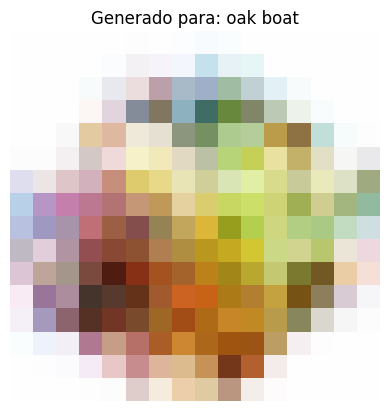

Época [340/2000] Loss_D: 0.2393  Loss_G: 2.9418


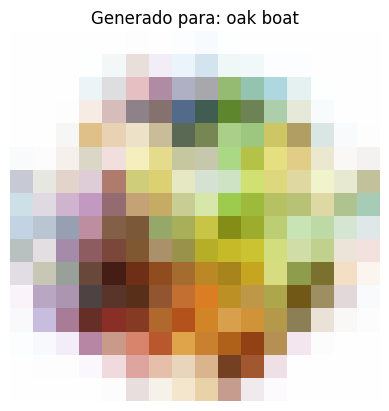

Época [360/2000] Loss_D: 0.3455  Loss_G: 1.4847


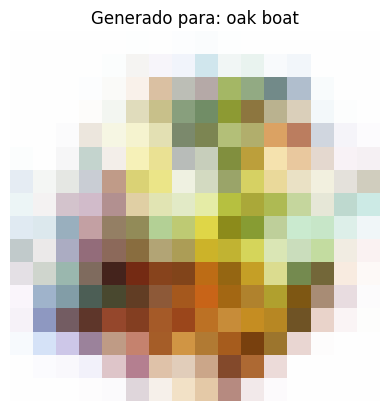

Época [380/2000] Loss_D: 0.2881  Loss_G: 2.6999


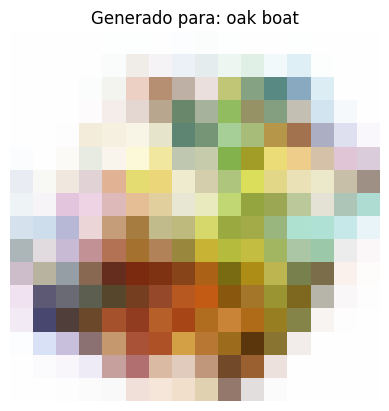

Época [400/2000] Loss_D: 0.3261  Loss_G: 2.2268


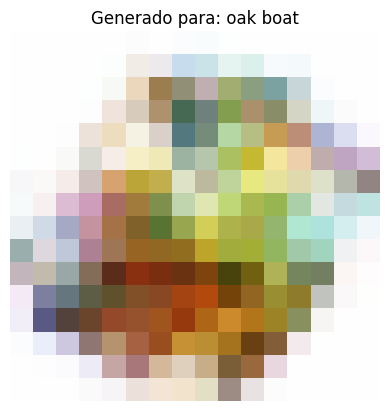

Época [420/2000] Loss_D: 0.4021  Loss_G: 1.2223


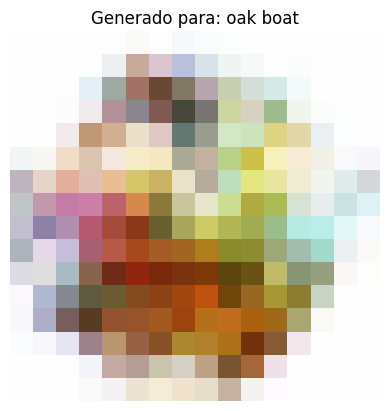

KeyboardInterrupt: 

In [20]:
# version primera de la funcion de entrenamiento, podria ser util
for epoch in range(num_epochs):
    for real_imgs, labels in dataloader:
        real_imgs = real_imgs.to(device)
        cond_emb = text_embedding(labels).to(device)
        b_size = real_imgs.size(0)

        # Etiquetas reales/falsas con label smoothing leve
        real_labels = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        fake_labels = torch.full((b_size,), 0.0, dtype=torch.float, device=device)

        # =========================================================
        # (1) Actualizar Discriminator: maximize log(D(x|y)) + log(1 - D(G(z|y)))
        # =========================================================
        D.zero_grad()

        # Salida del D con imágenes reales
        output_real = D(real_imgs, cond_emb)
        lossD_real = criterion(output_real, real_labels)

        # Generar imágenes falsas condicionales
        z = torch.randn(b_size, nz, device=device)
        fake_imgs = G(z, cond_emb)
        output_fake = D(fake_imgs.detach(), cond_emb)
        lossD_fake = criterion(output_fake, fake_labels)

        # Pérdida total del Discriminador
        lossD = (lossD_real + lossD_fake) / 2
        lossD.backward(retain_graph=True)
        optimizerD.step()

        # =========================================================
        # (2) Actualizar Generator: maximize log(D(G(z|y)))
        # =========================================================
        G.zero_grad()
        output = D(fake_imgs, cond_emb)
        lossG = criterion(output, real_labels)  # quiere que D piense que son reales
        lossG.backward()
        optimizerG.step()

    # =========================================================
    # LOGGING
    # =========================================================
    if epoch % 20 == 0:
        print(f"Época [{epoch}/{num_epochs}] "
              f"Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")

        # Generar una imagen de ejemplo condicional
        test_prompt = "oak boat"
        test_emb = txt_emb([test_prompt]).to(device)
        z = torch.randn(1, nz, device=device)
        fake_test = G(z, test_emb).detach().cpu()

        import matplotlib.pyplot as plt
        import torchvision.transforms.functional as TF

        img_vis = (fake_test[0] * 0.5 + 0.5).clamp(0, 1)
        plt.imshow(TF.to_pil_image(img_vis))
        plt.title(f"Generado para: {test_prompt}")
        plt.axis("off")
        plt.show()
